In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random 
from IPython.display import HTML
from skimage.draw import *

In [3]:
%load_ext Cython
import matplotlib.pyplot as plt
from numpy import linalg

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%cython
import numpy as np

class Particula:#En esta clase definimos los métodos fundamentales que debe seguir cada partícula

    def __init__(self, (float,float) posicion, (float,float) velocidad, float masa, float radio): 
       """comenzamos definiendo el método que debe 
        inicializar la clase, en este definimos los atributos básicos de la clase partícula
        las entradas masa y radio son de tipo float y las entradas de posición son tuplas conformadas por floats"""  
       self.radio=radio  
       self.masa=masa 
       
       self.posicion=np.array(posicion)   #Estas variables son arrays de numpy, y las trataremos como vectores
       self.velocidad=np.array(velocidad)
       self.velocidad_mag=np.linalg.norm(self.velocidad)#Este atributo no es otra cosa que la magnitud del vector velocidad
     
       """Creamos tres listas con los vectores posición y velocidad y velocidad_mag, posteriormente las usaremos
       para generar una lista con todos los valores que ha tenido la velocidad y posición"""
       
       self.velocidad_n=[self.velocidad]    ##Velocidad_n y posición_n son listas de vectores que contienen las listas correspondiente a
       self.posicion_n=[self.posicion]      ##todos los valores de estos vectores
       self.velocidad_mag_n=[self.velocidad_mag]
     
  ##########################################################################
    def paso_dt(self,float dt):   #Falta definir el valor que va a tomar dt  
       """Este método lo que hace es avanzar en el tiempo, cambia la posición de la partícula y agrega a las listas
       una actualización tanto de la posición de la partícula como la velocidad de la misma"""
      
       self.posicion=self.posicion + self.velocidad*dt  
       self.posicion_n.append(self.posicion) #Se añaden 
       self.velocidad_n.append(self.velocidad)
       self.velocidad_mag_n.append(self.velocidad_mag)
 ###############################################################################################
    def ver_colision_pp(self,otra_p):
       """Este método verifica si se dio luegar a una colisión entre dos partículas, las entradas
      son dos partículas, se definen sus radios y posiciones y se plantea una condición que indica 
      si las partículas chocaron"""
       cdef float r1=self.radio
       cdef float r2=otra_p.radio
       p1=self.posicion
       p2=otra_p.posicion
       cdef float sep=np.linalg.norm(p1-p2)#Norma del vector separación de ambas partículas.
       if sep-(r1+r2)<=0:#Si la separación es menor o igual a la suma de sus radios, entonces las partículas están en contacto y por lo tanto chocaron.
         return True
       else:
         return False
######################################################################################################
    def ver_colision_esquina(self, float Lx, float Ly):
       "Revisa si hay colisión con una esquina, Lx y Ly son las dimensiones horizontal y vertical de la caja respectivamente"
       extremo_izquierdo = self.posicion[0] - self.radio #da la posición del extremo izquido de la partícula
       extremo_inferior = self.posicion[1] - self.radio  #da la posición del extremo inferior de la partícula
       extremo_derecho  = self.posicion[0] + self.radio  #da la posición del extremo derech0 de la partícula
       extremo_superior = self.posicion[1] + self.radio  #da la posición del extremo superior de la partícula
       #Ahora construimos las variables donde se va a almacenar el hecho de chocar contra una esquina o no
       cdef bint choque_00 = extremo_izquierdo >0 and extremo_inferior> 0   #Esto corresponde a no chocar con la esquina (0,0)
       cdef bint choque_Lx0 = extremo_derecho <Lx and extremo_inferior > 0 #Esto corresponde a no chocar con la esquina (Lx,0)
       cdef bint choque_LxLy =  extremo_derecho <Lx and extremo_superior <Ly  #Esto corresponde a no chocar con la esquina (Lx,Ly)
       cdef bint choque_0Ly = extremo_izquierdo > 0 and extremo_superior <Ly  #Esto corresponde a chocar con la esquina (0,Ly)
       if not choque_00 or not choque_Lx0 or not choque_LxLy or not choque_0Ly:
         return  True 
       else:
         return False
       
        
#####################################################################################################
    def ver_colision_muro(self, float Lx, float Ly):
        """Este método revisa si la partícula ha chocado contra un muro."""
        """La condición ve que si la posición en "x" es diferente 0 o la longitud horizontal (Lx) de la caja y adicionalmente
     #  si la posición en "y" es diferente de 0 o la longitud vertical (Ly) entonces la partícula no está chocando contra un muro"""
        cdef bint choque_pared_derecha =  self.posicion[0] + self.radio <Lx   
        cdef bint choque_pared_izquierda = self.posicion[0] - self.radio>0
        #las condiciones corresponden a no chocar con esas paredes
        cdef bint choque_pared_superior = self.posicion[1] + self.radio <Ly 
        cdef bint choque_pared_inferior = self.posicion[1] - self.radio >0
        if choque_pared_derecha and choque_pared_izquierda and choque_pared_superior and choque_pared_inferior :
          return False
        else:
          return True 
        
######################################################################################################
    def resolver_colision_particula(self,otra_p):#Método que actualiza las velocidades de dos partículas después de chocar
      M1=self.masa    #Definimos las magnitudes a usar para resolver el choque
      M2=otra_p.masa
      p1=self.posicion
      p2=otra_p.posicion
      V1=self.velocidad
      V2=otra_p.velocidad
      if self.ver_colision_pp:
        self.velocidad= self.velocidad-((2*M2)/(M1+M2))*(np.dot(p1-p2,V1-V2)/(np.linalg.norm(p1-p2)**2))*(p1-p2)
        otra_p.velocidad= otra_p.velocidad-((2*M1)/(M1+M2))*(np.dot(p2-p1,V2-V1)/(np.linalg.norm(p2-p1)**2))*(p2-p1)
  

    def resolver_colision_muro(self,float Lx,float Ly): 
        """#Método que actualiza la velocidad después de que una partícula choca con un muro. Recibe la
        partícula y las dimensiones de la caja"""
        cdef bint choque_pared_derecha =  self.posicion[0] + self.radio <Lx   
        cdef bint choque_pared_izquierda = self.posicion[0] - self.radio>0
        #las condiciones corresponden a no chocar con esas paredes
        cdef bint choque_pared_superior = self.posicion[1] + self.radio <Ly 
        cdef bint choque_pared_inferior = self.posicion[1] - self.radio >0
        #Ahora miramos cual fue la pared con que se chocó e invertimos la coordenada teniendo en cuenta eso
        if not choque_pared_derecha or not choque_pared_izquierda:
            self.velocidad[0] = -1* self.velocidad[0]
        elif not choque_pared_superior or not choque_pared_inferior:
            self.velocidad[1] = -1* self.velocidad[1]
       
    def resolver_colision_esquina(self):
        """Método que actualiza la velocidad después de que una partícula choca con una esquina"""
        self.velocidad = -1* self.velocidad #se invierte todo el vector

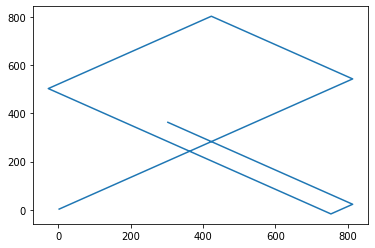

In [6]:
#Prueba partícula en dos dimensiones 
Lx = 800  #parametros de la caja 
Ly = 800
p1 = Particula((3,3),(300,200),1,1)
dt = 0.1
t = [None]
x = []   #lista con las posiciones en x
y = []   #lista con las posiciones en y
for n in range(100):
    p1.paso_dt(dt)
    t.append(n*dt)
    if p1.ver_colision_muro(Lx,Ly):
        p1.resolver_colision_muro(Lx,Ly)

for p in p1.posicion_n:
    x.append(p[0])
    y.append(p[1])

plt.plot(x,y)
plt.show()

ListaOf=[]
listaOf.append(x)
listaOf.append(y)


In [ ]:
BoxOf=np.zeros((800,800)) 
for x in range(0,len(ListaOf[0])):  #Creacion del primer gif con la clase 
  x2,y2=circle(ListaOf[0][x],ListaOf[1][x],20)
  BoxOf[x2,y2]=255
  gif.append(np.copy(BoxOf))
  BoxOf[x2,y2]=0

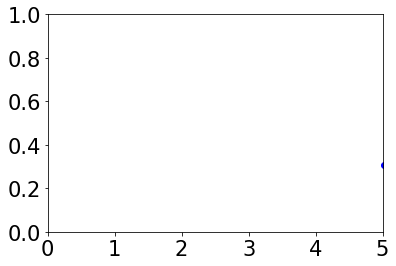

In [69]:
##########Opción1##############
fig, ax = plt.subplots()
ax.set_ylim(0, 1)
p=np.random.rand(20) ####Ingresando p en points, obtendremos particulas aleatorias en el plot 
x=random.randint(0,5) ##Escoge la posicion x de la particula en un rango de 0 a 5 tomando valores enteros 
y=random.random()    ###Escoge la posicion y de la particula en un rango de 0 a 1 tomando valores flotantes 
points, = ax.plot(x,y, 'bo')  ## creo un plot inicial con la informacion de la particula 

def recorrido():
  ax.set_xlim(0,5)
  ax.set_ylim(0,1)
  return points,

def choque_x(x_1):
  if x_1>5 or x_1<0:
    return True

def choque_y(y_1):
  if y_1>1 or y_1<0:
    return True

def puntos(x):
  dt=0.01
  vx=2
  vy=0.2
  mx=choque_x(x)
  my=choque_y(y)

  x_paso=x+vx*dt
  y_paso=y+vy*dt
  if mx==True:
    vx *= -1
    vy *= -1

  if my==True:
    vx *= -1
    vy *= -1

  x_paso=x+vx*dt
  y_paso=y+vy*dt

  points.set_data(x_paso,y_paso) 
  return points,
  

ani=FuncAnimation(fig,puntos,frames=6,init_func=recorrido,blit=True)
HTML(ani.to_jshtml()) 

In [7]:
##########Opción2##############
def recorrido(x,y,box,frames): #Función que me crea el recorrido de la prueba para el gif 
  dt=0.01
  vx=200
  vy=100
  i=1
  xd=[] #lista donde estara la posicion x del centro en un instante t de tiempo 
  yd=[] #lista donde estara la posicion y del centro en un instante t de tiempo 

  x_paso=x+vx*dt
  y_paso=y+vy*dt

  xd.append(x)#Agrego la primera posicion de la particula 
  yd.append(y) 
  xd.append(int(x_paso)) #agrego la segunda posicion de la particula 
  yd.append(int(y_paso))

  while i<frames: #Veo los choques y voy agregando los pasos posteriores al segundo instante de tiempo 
    i+=1
    if x_paso>100 and x_paso<box.shape[0] and y_paso>100 and y_paso<box.shape[0]:
      x_paso=x_paso+vx*dt
      y_paso=y_paso+vy*dt
      xd.append(int(x_paso))
      yd.append(int(y_paso))  
    elif x_paso<100 or x_paso>box.shape[0]:
      x_paso=x_paso+(-1*vx)*dt
      y_paso=y_paso+(-1*vy)*dt
      xd.append(int(x_paso))
      yd.append(int(y_paso))
    elif y_paso<100 or y_paso>box.shape[1]:
      x_paso=x_paso+(-1*vx)*dt
      y_paso=y_paso+(-1*vy)*dt
      xd.append(int(x_paso))
      yd.append(int(y_paso))
  return xd, yd

    
box1=np.zeros((700,700)) #Creo la caja donde estara confinada la particula 
box2=np.zeros((800,800)) #Creo el plot donde se vera la particula 
x1,y1=circle(100,100,20) #creo la particula con radio 20
img=recorrido(100,100,box1,1000) #Se genera el recorrido de la particula antes del primer choque 

gif=[]  #Aqui estaran las matrices que me generan la imagen de la particula en un instante t de tiempo 

for x in range(0,len(img[0])):  #Creo dichas imagenes y las agrego a la lista gif 
  x2,y2=circle(img[0][x],img[1][x],20)
  box2[x2,y2]=255
  gif.append(np.copy(box2))
  box2[x2,y2]=0




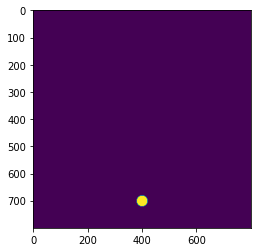

In [14]:
for x in range(0,len(gif)):  #descomprimo todas las imagenes en una carpeta llamada Gif
  plt.imshow(gif[x])
  plt.savefig("/content/drive/MyDrive/Colab Notebooks/Proyecto /Gif/img{0}.png".format(x), bbox_inches='tight') #Los archivos no se guardan en el orden deseado ¿qué podemos hacer?



In [12]:
import glob

GifFinal = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/Proyecto /Gif/*.png')) #Con el modulo glob hago una lista donde esta la informacion de la carpeta Gif 
GifFinal.sort() #intento ordenar las imagenes de la carpeta Gif
import moviepy.editor as mpy

fps = 50 #Utilizando el modulo moviepy.editor creo un gif a 50fps con las imagenes de la carpeta Gif 
clip = mpy.ImageSequenceClip(GifFinal, fps=fps)
clip.write_gif('movie1.1.gif')



[MoviePy] Building file movie1.0.gif with imageio


100%|██████████| 100/100 [00:01<00:00, 87.20it/s]


(3, 0.5007443046869859)


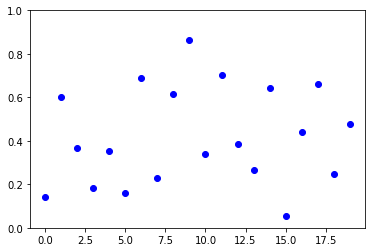

In [ ]:
##############BasuraQueVoyUtilizando1#####################

fig, ax = plt.subplots()
ax.set_ylim(0, 1)
p=np.random.rand(20)
x=random.randint(0,5)
y=random.random()
points = ax.plot(p, 'bo')


print((x,y))


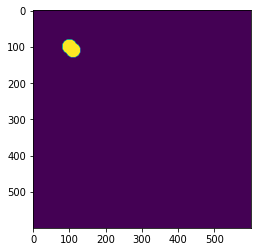

In [ ]:
##############BasuraQueVoyUtilizando2#####################
box1=np.zeros((600,600))
x1,y1=circle(100,100,20)
box1[x1,y1]=255
x2,y2=circle(110,110,20)
box1[x2,y2]=255
plt.imshow(box1)

#for x in range(0,len(m[0])):
#  x2,y2=circle(m[0][x],m[1][x],20)
#  box2[x2,y2]=255


#########################################################

file_names = sorted((fn for fn in "/content/Gif"  if fn.startswith('surface')))

with io.get_writer('surface.gif', mode='I', duration=0.5) as writer:
    for filename in file_names:
        image = io.imread(filename)
        writer.append_data(image)
writer.close()